In [5]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torch.nn import functional as F
from torch.nn import init

In [12]:
# [64,128,256,512,512]

def init_weights(net, init_type='normal', init_gain=0.02):
        """Initialize network weights.

        Parameters:
            net (network)   -- network to be initialized
            init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
            init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

        We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
        work better for some applications. Feel free to try yourself.
        """

        def init_func(m):  # define the initialization function
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    init.normal_(m.weight.data, 0.0, init_gain)
                elif init_type == 'xavier':
                    init.xavier_normal_(m.weight.data, gain=init_gain)
                elif init_type == 'kaiming':
                    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    init.orthogonal_(m.weight.data, gain=init_gain)
                else:
                    raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias.data, 0.0)
            elif classname.find(
                    'BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
                init.normal_(m.weight.data, 1.0, init_gain)
                init.constant_(m.bias.data, 0.0)

        net.apply(init_func)  # apply the initialization function <init_func>

In [256]:
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def mean_variance_norm(feat):
    size = feat.size()
    mean, std = calc_mean_std(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat


class AdaAttn(nn.Module):

    def __init__(self, in_planes, max_sample=256 * 256, key_planes=None):
        super(AdaAttn, self).__init__()
        if key_planes is None:
            key_planes = in_planes
        self.f = nn.Conv2d(key_planes, key_planes, (1, 1))
        self.g = nn.Conv2d(key_planes, key_planes, (1, 1))
        self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = nn.Softmax(dim=-1)
        self.max_sample = max_sample

    def forward(self, content, style, content_key, style_key, seed=None):
        F = self.f(content_key)
        G = self.g(style_key)
        H = self.h(style)
        b, _, h_g, w_g = G.size()
        G = G.view(b, -1, w_g * h_g).contiguous()
        if w_g * h_g > self.max_sample:
            if seed is not None:
                torch.manual_seed(seed)
            index = torch.randperm(w_g * h_g).to(content.device)[:self.max_sample]
            G = G[:, :, index]
            style_flat = H.view(b, -1, w_g * h_g)[:, :, index].transpose(1, 2).contiguous()
        else:
            style_flat = H.view(b, -1, w_g * h_g).transpose(1, 2).contiguous()
        b, _, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        S = torch.bmm(F, G)
        # S: b, n_c, n_s
        S = self.sm(S)
        # mean: b, n_c, c
        mean = torch.bmm(S, style_flat)
        # std: b, n_c, c
        std = torch.sqrt(torch.relu(torch.bmm(S, style_flat ** 2) - mean ** 2))
        # mean, std: b, c, h, w
        mean = mean.view(b, h, w, -1).permute(0, 3, 1, 2).contiguous()
        std = std.view(b, h, w, -1).permute(0, 3, 1, 2).contiguous()
        return std * mean_variance_norm(content) + mean


class Transformer(nn.Module):

    def __init__(self, in_planes, key_planes=None, shallow_layer=True):
        super(Transformer, self).__init__()
        self.attn_adain_4_1 = AdaAttN(in_planes=in_planes, key_planes=key_planes)
        self.attn_adain_5_1 = AdaAttN(in_planes=in_planes,
                                        key_planes=key_planes + 512 if shallow_layer else key_planes)
        self.upsample5_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_planes, in_planes, (3, 3))

    def forward(self, content4_1, style4_1, content5_1, style5_1,
                content4_1_key, style4_1_key, content5_1_key, style5_1_key, seed=None):
        return self.merge_conv(self.merge_conv_pad(
            self.attn_adain_4_1(content4_1, style4_1, content4_1_key, style4_1_key, seed=seed) +
            self.upsample5_1(self.attn_adain_5_1(content5_1, style5_1, content5_1_key, style5_1_key, seed=seed))))


class Decoder(nn.Module):

    def __init__(self, skip_connection_3=True):
        super(Decoder, self).__init__()
        self.decoder_layer_1 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 256, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.decoder_layer_2 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256 + 256 if skip_connection_3 else 256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 128, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 64, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 3, (3, 3))
        )

    def forward(self, cs, c_adain_3_feat=None):
        cs = self.decoder_layer_1(cs)
        if c_adain_3_feat is None:
            cs = self.decoder_layer_2(cs)
        else:
            cs = self.decoder_layer_2(torch.cat((cs, c_adain_3_feat), dim=1))
        return cs


In [257]:
    
from itertools import chain

class NST_Model(nn.Module):
    
    def __init__(self,device):
        super(NST_Model,self).__init__()
        
        # set_input function
        self.c = None
        self.s = None
        self.cs = None
        self.c_feats = None
        self.s_feats = None
                
        self.device=device
        
        self.decoder = Decoder(skip_connection_3=True).to(device)
        init_weights(self.decoder)
        
        # Transformer
        p1 = 512+256+128+64
        p2 = 512
        self.transformer = Transformer(p2,p1).to(device)
        init_weights(self.transformer)
        
        self.ada_3 = AdaAttn(in_planes =256,key_planes=256 + 128 + 64).to(device)
        init_weights(self.ada_3)
     
        
    
        image_encoder = nn.Sequential(
            nn.Conv2d(3, 3, (1, 1)),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 64, (3, 3)),
            nn.ReLU(),  # relu1-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),  # relu1-2
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),  # relu2-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),  # relu2-2
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 256, (3, 3)),
            nn.ReLU(),  # relu3-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-4
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 512, (3, 3)),
            nn.ReLU(),  # relu4-1, this is the last layer used
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-4
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU()  # relu5-4
        )
        image_encoder.load_state_dict(torch.load('vgg_normalised.pth'))
        enc_layers = list(image_encoder.children())
        enc_1 =    nn.Sequential(*enc_layers[:4]).to(self.device)
        enc_2 =  nn.Sequential(*enc_layers[4:11]).to(self.device)
        enc_3 = nn.Sequential(*enc_layers[11:18]).to(self.device)
        enc_4 = nn.Sequential(*enc_layers[18:31]).to(self.device)
        enc_5 = nn.Sequential(*enc_layers[31:44]).to(self.device)
        self.encoding_layers = [enc_1, enc_2, enc_3, enc_4, enc_5]
        for layer in self.encoding_layers:
            for param in layer.parameters():
                param.requires_grad = False
                
        self.model_parameters = []
        self.model_parameters.append(self.decoder.parameters())
        self.model_parameters.append(self.transformer.parameters())
        self.model_parameters.append(self.ada_3.parameters())
        self.optimizer = torch.optim.Adam(chain(*self.model_parameters),lr=0.0001,betas=(0.9,0.999))
        
        lambda_rule = lambda epoch :  0.95 ** epoch

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda_rule)

        
        self.criterion = torch.nn.MSELoss().to(self.device)

        self.local_loss = torch.tensor(0.,device=self.device)
        self.global_loss = torch.tensor(0.,device=self.device)
        self.total_loss = torch.tensor(0.,device=self.device)
        
        self.softmax = nn.Softmax(dim=-1)

        
    

        
    def get_intermediate(self,image):
        out = []
        for i in range(5):
            if len(out)==0:
                out.append(self.encoding_layers[i](image))
            else:
                out.append(self.encoding_layers[i](out[-1]))
        return out
    
    def get_adainp(self,feats,last_layer_idx):
        out = []
        for i in range(last_layer_idx):
            _,_,h,w = feats[last_layer_idx].size()
            out.append(mean_variance_norm(F.interpolate(feats[i],size=(h,w))))
        out.append(mean_variance_norm(feats[last_layer_idx]))
        return torch.cat(out,dim=1)
        
    def set_input(self,c,s):
        self.c = c
        self.s = s
        self.c_feats = self.get_intermediate(c)
        self.s_feats = self.get_intermediate(s)
        
    def forward(self):
        
        c_adain_feat_3 = self.ada_3(self.c_feats[2], self.s_feats[2], self.get_adainp(self.c_feats, 2),
                                                   self.get_adainp(self.s_feats, 2))
        cs = self.transformer(self.c_feats[3],self.s_feats[3], self.c_feats[4], self.s_feats[4],
                             self.get_adainp(self.c_feats,3), self.get_adainp(self.s_feats,3),self.get_adainp(self.c_feats,4),
                             self.get_adainp(self.s_feats,4))
        
        self.cs = self.decoder(cs,c_adain_feat_3)
        
    def get_global_loss(self,cs_feats):
        self.global_loss = torch.tensor(0.,device=self.device)
        for i in range(0,5):
            s_mean,s_std = calc_mean_std(self.s_feats[i])
            cs_mean,cs_std = calc_mean_std(cs_feats[i])
            self.global_loss+= self.criterion(s_mean,cs_mean) + self.criterion(s_std,cs_std)
        
    
    def get_local_loss(self,cs_feats):
        self.local_loss = torch.tensor(0.,device=self.device)
        
        for i in range(0,5):
            
            c_feat = self.get_adainp(self.c_feats,i)
            s_feat = self.get_adainp(self.s_feats,i)
            
            s = self.s_feats[i]
            c = self.c_feats[i]
            
            norm_c = mean_variance_norm(c)
            b,c,h,w = c_feat.size()
            query = c_feat
            key = s_feat
            value = s
            value_flat = value.view(b,-1,w*h)
            attention_map = self.softmax(torch.bmm(torch.transpose(query.view(b,-1,w*h),1,2).contiguous(),key.view(b,-1,w*h)))
            attention_map_t = torch.transpose(attention_map,1,2).contiguous()
            mean = torch.bmm(value_flat,attention_map_t)
            std = torch.sqrt(torch.relu(torch.bmm(value_flat**2,attention_map_t) - mean**2))
            mean = mean.view(b, h, w, -1).permute(0, 3, 1, 2).contiguous() # ....
            std = std.view(b, h, w, -1).permute(0, 3, 1, 2).contiguous() # .....
            
            self.local_loss += self.criterion(cs_feats[i],std * norm_c + mean)
            
        
    def compute_loss(self):
        cs_feats = self.get_intermediate(self.cs)
        self.get_global_loss(cs_feats)
        self.get_local_loss(cs_feats)
        
        self.global_loss = 10 * self.global_loss 
        self.local_loss = 3 * self.local_loss
        


        
    
    def train_one_step(self): 
        
        self.optimizer.zero_grad()
        
        self.forward()
        self.compute_loss()
        
        self.total_loss = self.global_loss + self.local_loss
        
        self.total_loss.backward()
        self.optimizer.step()
        


        print('global loss : {}, local loss : {}'.format(self.global_loss,self.local_loss))
    
    
    def update_learning_rate(self):
        old_lr = self.optimizer.param_groups[0]['lr']
        self.scheduler.step()
        lr = self.optimizer.param_groups[0]['lr']
        
        print('learning rate %.7f -> %.7f' % (old_lr, lr))
    
    def evaluate(self):
        with torch.no_grad():

            self.forward()
            
            return self.cs
            
    
  
             

In [300]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import v2
import imghdr

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.cont_dir = os.path.join(img_dir,'content_images')
        self.sty_dir = os.path.join(img_dir,'style_images')
        
        self.content_image_labels = [file for file in os.listdir(self.cont_dir) if imghdr.what(os.path.join(self.cont_dir, file)) is not None]
        self.style_image_labels = [file for file in os.listdir(self.sty_dir) if imghdr.what(os.path.join(self.sty_dir, file)) is not None]
        
    

    def __len__(self):
        
        return len(self.style_image_labels)

    def __getitem__(self, idx):
    

        content_img_path = os.path.join(self.cont_dir,self.content_image_labels[idx])
        content_image = read_image(content_img_path)
        style_img_path = os.path.join(self.sty_dir,self.style_image_labels[idx])
        style_image = read_image(style_img_path)
        
        
        if self.transform:
            content_image = self.transform(content_image)
            style_image = self.transform(style_image)
            
        return content_image,style_image
    
transform = v2.Compose([v2.Resize((512,512)),v2.RandomResizedCrop((128,128)),v2.ToDtype(torch.float32, scale=True)])
dataset = CustomImageDataset('archive',transform=transform)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [301]:
test_transform = v2.Compose([v2.Resize((256,256)),v2.ToDtype(torch.float32, scale=True)])

test_dataset = CustomImageDataset('images',transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [302]:
print(len(train_dataloader))

5000


In [303]:
from tqdm import tqdm
epochs=round(1000/len(train_dataloader))
device='mps'

# device = 'cpu' if torch.cuda.is_available() else 'cpu'
print(device)

model = NST_Model(device=device)

mps


In [304]:
epochs = 20

In [ ]:
for epoch in range(epochs):
    print('epoch : {}'.format(epoch),"_"*10)
    loss=0
    for data in (train_dataloader):
        
    
        c_img ,s_img = data
        c_img = c_img.to(device)
        s_img = s_img.to(device)
        
        
        model.set_input(c_img,s_img)
        
        model.train_one_step()
        loss+=model.total_loss
    model.update_learning_rate()
        


epoch : 0 __________
global loss : 104.5261001586914, local loss : 58.592926025390625
global loss : 100.77899932861328, local loss : 58.56468200683594
global loss : 172.7775421142578, local loss : 137.2461395263672
global loss : 89.50984191894531, local loss : 59.7955322265625
global loss : 171.7613525390625, local loss : 187.95748901367188
global loss : 79.83120727539062, local loss : 120.70571899414062
global loss : 77.2928466796875, local loss : 84.97279357910156
global loss : 51.96943283081055, local loss : 50.756858825683594
global loss : 60.406829833984375, local loss : 41.67904281616211
global loss : 110.92546081542969, local loss : 88.7318115234375
global loss : 64.17809295654297, local loss : 36.99761962890625
global loss : 58.16181182861328, local loss : 69.00360107421875
global loss : 97.28974914550781, local loss : 95.19453430175781
global loss : 102.2037582397461, local loss : 92.61172485351562
global loss : 131.3865509033203, local loss : 140.572265625
global loss : 135.5

global loss : 104.73652648925781, local loss : 117.59589385986328
global loss : 60.522308349609375, local loss : 89.31826782226562
global loss : 128.99305725097656, local loss : 105.83816528320312
global loss : 125.7962875366211, local loss : 126.61882781982422
global loss : 104.5054931640625, local loss : 109.82073974609375
global loss : 102.79702758789062, local loss : 70.39482879638672
global loss : 111.4350814819336, local loss : 86.52967071533203
global loss : 115.56346893310547, local loss : 73.86773681640625
global loss : 101.65706634521484, local loss : 140.86026000976562
global loss : 243.23716735839844, local loss : 115.01284790039062
global loss : 54.964019775390625, local loss : 77.13166809082031
global loss : 112.43507385253906, local loss : 99.97044372558594
global loss : 60.938297271728516, local loss : 180.694580078125
global loss : 86.52557373046875, local loss : 181.123291015625
global loss : 128.00021362304688, local loss : 162.70443725585938
global loss : 61.1038246

global loss : 62.706661224365234, local loss : 48.12769317626953
global loss : 64.42864227294922, local loss : 68.84899139404297
global loss : 76.36430358886719, local loss : 120.6448974609375
global loss : 117.03488159179688, local loss : 134.5443572998047
global loss : 25.228172302246094, local loss : 91.15379333496094
global loss : 88.45252990722656, local loss : 146.2725830078125
global loss : 50.59016799926758, local loss : 61.18069839477539
global loss : 140.95013427734375, local loss : 167.59466552734375
global loss : 40.172847747802734, local loss : 70.18943786621094
global loss : 43.48400115966797, local loss : 52.235931396484375
global loss : 70.39645385742188, local loss : 79.97623443603516
global loss : 76.84986877441406, local loss : 127.3821029663086
global loss : 137.7720489501953, local loss : 119.9230728149414
global loss : 54.019775390625, local loss : 195.1669921875
global loss : 60.21468734741211, local loss : 41.72777557373047
global loss : 54.874427795410156, loca

global loss : 42.0191650390625, local loss : 35.380401611328125
global loss : 29.484834671020508, local loss : 27.30124855041504
global loss : 54.69234848022461, local loss : 86.22882080078125
global loss : 145.93374633789062, local loss : 200.13119506835938
global loss : 124.15264129638672, local loss : 245.9799041748047
global loss : 45.71002960205078, local loss : 65.35035705566406
global loss : 103.48030090332031, local loss : 124.1561508178711
global loss : 150.9210205078125, local loss : 212.7440643310547
global loss : 132.9337158203125, local loss : 215.18600463867188
global loss : 118.33625793457031, local loss : 175.21495056152344
global loss : 111.44477844238281, local loss : 179.83763122558594
global loss : 22.00643539428711, local loss : 40.57047653198242
global loss : 60.83655548095703, local loss : 97.85520935058594
global loss : 22.635526657104492, local loss : 58.43202209472656
global loss : 24.401865005493164, local loss : 55.975303649902344
global loss : 25.9741935729

global loss : 26.606643676757812, local loss : 75.90121459960938
global loss : 78.42486572265625, local loss : 109.33741760253906
global loss : 20.703304290771484, local loss : 67.18482208251953
global loss : 29.954137802124023, local loss : 64.60933685302734
global loss : 49.122093200683594, local loss : 46.1067008972168
global loss : 76.49750518798828, local loss : 140.74420166015625
global loss : 31.24692153930664, local loss : 114.57260131835938
global loss : 39.14094924926758, local loss : 115.05265808105469
global loss : 61.88440704345703, local loss : 76.44413757324219
global loss : 28.378793716430664, local loss : 41.062355041503906
global loss : 126.08987426757812, local loss : 160.7566680908203
global loss : 56.54059600830078, local loss : 126.3028793334961
global loss : 65.85371398925781, local loss : 109.42056274414062
global loss : 84.71611022949219, local loss : 166.1142578125
global loss : 45.82387924194336, local loss : 76.78837585449219
global loss : 101.93814086914062

global loss : 69.65027618408203, local loss : 100.40847778320312
global loss : 95.77984619140625, local loss : 173.06605529785156
global loss : 51.2299919128418, local loss : 78.60441589355469
global loss : 49.127254486083984, local loss : 82.31979370117188
global loss : 55.00404357910156, local loss : 115.00567626953125
global loss : 38.51885223388672, local loss : 51.75032043457031
global loss : 68.02017974853516, local loss : 91.09466552734375
global loss : 93.08755493164062, local loss : 259.337890625
global loss : 76.43077850341797, local loss : 210.42514038085938
global loss : 47.57637405395508, local loss : 94.01470947265625
global loss : 44.70764923095703, local loss : 93.73246002197266
global loss : 23.940399169921875, local loss : 39.309913635253906
global loss : 59.744842529296875, local loss : 84.7762680053711
global loss : 73.516357421875, local loss : 154.83941650390625
global loss : 243.19100952148438, local loss : 255.15582275390625
global loss : 107.7726058959961, loca

global loss : 53.607208251953125, local loss : 54.7075080871582
global loss : 34.36000061035156, local loss : 83.55982208251953
global loss : 49.2386474609375, local loss : 131.58349609375
global loss : 103.43669891357422, local loss : 147.6732940673828
global loss : 29.02425765991211, local loss : 55.89848327636719
global loss : 26.704492568969727, local loss : 85.11729431152344
global loss : 63.057777404785156, local loss : 53.59605407714844
global loss : 63.36763381958008, local loss : 117.84185028076172
global loss : 131.50323486328125, local loss : 261.5254211425781
global loss : 61.9349479675293, local loss : 159.4740447998047
global loss : 73.86339569091797, local loss : 55.95621871948242
global loss : 77.6748275756836, local loss : 110.2792739868164
global loss : 97.41730499267578, local loss : 135.6707763671875
global loss : 70.8702621459961, local loss : 156.18934631347656
global loss : 30.896093368530273, local loss : 114.13671875
global loss : 24.074251174926758, local loss

global loss : 130.0048828125, local loss : 107.49063110351562
global loss : 32.312950134277344, local loss : 159.78964233398438
global loss : 129.13270568847656, local loss : 103.35470581054688
global loss : 57.21003723144531, local loss : 153.93179321289062
global loss : 52.812355041503906, local loss : 78.53144836425781
global loss : 79.51681518554688, local loss : 82.41217803955078
global loss : 73.81591033935547, local loss : 91.14762878417969
global loss : 65.13325500488281, local loss : 132.25131225585938
global loss : 49.98614501953125, local loss : 190.99974060058594
global loss : 30.384693145751953, local loss : 146.9676971435547
global loss : 83.92599487304688, local loss : 117.3936996459961
global loss : 58.99837112426758, local loss : 101.842529296875
global loss : 24.13372802734375, local loss : 37.41731262207031
global loss : 41.35376739501953, local loss : 92.9173583984375
global loss : 19.66838836669922, local loss : 60.916656494140625
global loss : 51.34262466430664, l

global loss : 132.73129272460938, local loss : 35.061641693115234
global loss : 105.77397155761719, local loss : 185.01878356933594
global loss : 74.55340576171875, local loss : 111.2113265991211
global loss : 49.49203872680664, local loss : 78.20079803466797
global loss : 48.82648468017578, local loss : 96.10536193847656
global loss : 39.3055419921875, local loss : 48.46654510498047
global loss : 54.8336181640625, local loss : 41.71495056152344
global loss : 102.01911163330078, local loss : 135.7926025390625
global loss : 55.46781921386719, local loss : 111.86016082763672
global loss : 36.761592864990234, local loss : 67.59001922607422
global loss : 43.60067367553711, local loss : 83.44329833984375
global loss : 162.46145629882812, local loss : 187.05731201171875
global loss : 48.24176788330078, local loss : 54.862037658691406


In [292]:
from torchvision.utils import save_image
for i,data in enumerate(test_dataloader):
    c_img ,s_img = data
    c_img = c_img.to(device)
    s_img = s_img.to(device)


    model.set_input(c_img,s_img)

    pred = model.evaluate()
#     pred = pred.detach().cpu()[0].permute(2,1,0).numpy()

    save_image(pred,f'out{i}.png',normalize=True)
    
    



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


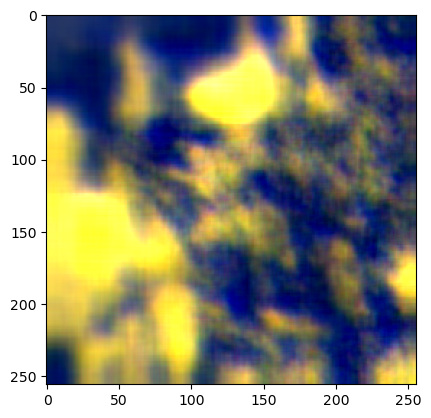

In [177]:
import matplotlib.pyplot as plt
